In [1]:
import aiohttp
import aiomoex

from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
START_DATE = '2022-05-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

In [3]:
async def fetch_moex_data(start_date=START_DATE, end_date=END_DATE, timeframe='H', ticker='SBER'):

    # Маппинг интервалов
    interval_map = {'D': 24, 'W': 7, 'H': 60, 'M': 31, 'm': 1}
    interval = interval_map.get(timeframe, 60)
    print(f"📊 Загружаем данные для {ticker} с {start_date} по {end_date} (таймфрейм: {timeframe})")

    async with aiohttp.ClientSession() as session:
        # Запрашиваем свечные данные
        data = await aiomoex.get_market_candles(
            session,
            security=ticker,
            interval=interval,
            start=start_date,
            end=end_date
        )

    # Проверяем, есть ли данные
    if not data:
        raise ValueError(f"❌ Не удалось получить данные для {ticker}")

    # Создаем DataFrame
    df = pd.DataFrame(data)

    df = df.rename(columns={'begin': 'date'})

    # Преобразуем дату в datetime и ставим индекс
    df['date'] = pd.to_datetime(df['date'])
    # df.set_index('date', inplace=True)

    # Оставляем только нужные столбцы
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

    print(f"✅ Загружено {len(df)} свечей для {ticker}")

    return df.sort_values('date')

df = await fetch_moex_data(ticker="SBER", timeframe='H')
df.head()

📊 Загружаем данные для SBER с 2022-05-01 по 2025-03-17 (таймфрейм: H)
✅ Загружено 10617 свечей для SBER


,date,open,high,low,close,volume
0,2022-05-04 09:00:00,129.10,129.10,129.10,129.10,111560
1,2022-05-04 10:00:00,129.10,131.50,125.77,127.00,17793280
2,2022-05-04 11:00:00,127.05,127.50,123.60,123.95,13508120
3,2022-05-04 12:00:00,123.89,126.23,123.60,125.44,6536410
4,2022-05-04 13:00:00,125.44,126.21,124.61,125.35,3540730


In [4]:
# Create the feature : ( close[t] - close[t-1] )/ close[t-1]
df["feature_close"] = df["close"].pct_change()

# Create the feature : open[t] / close[t]
df["feature_open"] = df["open"]/df["close"]

# Create the feature : high[t] / close[t]
df["feature_high"] = df["high"]/df["close"]

# Create the feature : low[t] / close[t]
df["feature_low"] = df["low"] / df["close"]

 # Create the feature : volume[t] / max(*volume[t-7*24:t+1])
df["feature_volume"] = df["volume"] / df["volume"].rolling(7*24).max()

In [5]:
df = df.dropna().reset_index(drop=True)
df.head()

,date,open,high,low,close,volume,feature_close,feature_open,feature_high,feature_low,feature_volume
0,2022-05-30 16:00:00,121.20,121.32,120.47,121.31,3283100,0.000990,0.999093,1.000082,0.993076,0.184513
1,2022-05-30 17:00:00,121.31,121.64,120.94,121.49,1963020,0.001484,0.998518,1.001235,0.995473,0.110324
2,2022-05-30 18:00:00,121.49,121.54,120.21,120.67,2634790,-0.006750,1.006795,1.007210,0.996188,0.175531
3,2022-05-31 09:00:00,120.00,120.00,120.00,120.00,75730,-0.005552,1.000000,1.000000,1.000000,0.005045
4,2022-05-31 10:00:00,120.00,120.00,118.05,118.62,10739030,-0.011500,1.011634,1.011634,0.995195,0.715440


In [6]:
from stable_baselines3 import PPO
# from stable_baselines3.common.vec_env import DummyVecEnv
# import torch
# import torch.nn as nn
# from stable_baselines3.common.policies import ActorCriticPolicy
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.callbacks import CallbackList

In [7]:
def reward_function(history, 
                    upward_bonus=5,       # усиленный бонус для роста
                    downward_bonus=0.005,    
                    penalty_factor=1.0, 
                    holding_penalty=0.5,  # уменьшаем штраф за удержание в позитивном тренде
                    # holding_penalty=0.001,  # уменьшаем штраф за удержание в позитивном тренде
                    uncertainty_threshold=0.05,
                    hold_threshold=12,        # минимальное число шагов, чтобы удержание считалось долгосрочным
                    exit_penalty=0.025):      # штраф за слишком ранний выход из позиции
    """
    Функция награды для пространства действий из двух позиций:
      0 – вне рынка,
      1 – в позиции.
    
    Параметры:
      history: словарь с ключами:
          - "portfolio_valuation": список оценок портфеля
          - "data_close": список цен закрытия
          - "position": список позиций агента (0 или 1)
      upward_bonus: базовый бонус для удержания в позиции при росте рынка
      downward_bonus: бонус для агента, если он вне рынка и рынок падает
      penalty_factor: коэффициент усиления штрафа при неблагоприятном движении, когда агент в позиции
      holding_penalty: дополнительный штраф за каждый шаг удержания активной позиции
      uncertainty_threshold: порог изменения цены, ниже которого рынок считается неопределённым
      hold_threshold: минимальное число шагов удержания, после которого агент получает дополнительный бонус за удержание
      exit_penalty: штраф за слишком быстрый выход из позиции (если агент продаёт до достижения hold_threshold)
      
    Возвращает:
      итоговую награду (float)
    """
    # Базовая награда – логарифмический доход портфеля за последний шаг
    base_reward = np.log(history["portfolio_valuation"][-1] / history["portfolio_valuation"][-2])
    
    # Рассчитываем относительное изменение цены за последний шаг
    previous_price = history["data_close"][-2]
    current_price = history["data_close"][-1]
    relative_change = (current_price - previous_price) / previous_price
    
    # Определяем текущую позицию (0 или 1)
    current_position = history["position"][-1]
    
    # Считаем, сколько шагов подряд агент находился в текущей позиции
    consecutive_steps = 0
    for pos in reversed(history["position"]):
        if pos == current_position:
            consecutive_steps += 1
        else:
            break

    # Инициализируем итоговую награду значением базовой награды
    reward = base_reward

    if current_position == 1:
        # Агент в позиции
        if relative_change > uncertainty_threshold:
            # Растущий рынок
            bonus = upward_bonus * consecutive_steps * relative_change
            reward += bonus
            # Если агент удерживает позицию достаточно долго, даем дополнительный бонус
            if consecutive_steps >= hold_threshold:
                reward += 0.005 * (consecutive_steps - hold_threshold)
        elif relative_change < -uncertainty_threshold:
            # Падающий рынок, агент в позиции – штраф за удержание убыточной позиции
            penalty = penalty_factor * abs(relative_change) * consecutive_steps + holding_penalty * consecutive_steps
            reward -= penalty
        else:
            # Небольшое изменение цены – небольшой штраф за удержание позиции
            reward -= holding_penalty * consecutive_steps
    else:
        # Агент вне рынка (позиция 0)
        if relative_change > uncertainty_threshold:
            # Растущий рынок, агент вне рынка – штраф за упущенную возможность
            reward -= upward_bonus * consecutive_steps
            # Если агент только что вышел из позиции и удержание было коротким, добавляем штраф за ранний выход
            if consecutive_steps < hold_threshold:
                reward -= exit_penalty
        elif relative_change < -uncertainty_threshold:
            # Падающий рынок, агент вне рынка – бонус за избежание потерь
            reward += downward_bonus * consecutive_steps
        # При неопределённом движении базовая награда остается без изменений

    return reward

In [8]:
import gymnasium as gym
import gym_trading_env

env = gym.make("TradingEnv",
        name= "SBER",
        reward_function = reward_function,
        df = df, # Your dataset with your custom features
        positions = [0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        # positions = [-1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.03/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

In [9]:
# total_timesteps = 200_000
total_timesteps = len(df) * 50
update_interval = 2048  # количество временных шагов для одного обновления (rollout)
timesteps = 0

In [10]:
from stable_baselines3.common.callbacks import BaseCallback

class SaveTransitionsCallback(BaseCallback):
    """
    Callback для сохранения наблюдений, действий и наград из rollout buffer.
    Данные сохраняются после завершения каждого rollout.
    """
    def __init__(self, verbose=0):
        super(SaveTransitionsCallback, self).__init__(verbose)
        self.states = []    # Список для сохранения наблюдений
        self.actions = []   # Список для сохранения действий
        self.rewards = []   # Список для сохранения наград

    def _on_step(self) -> bool:
        # Просто возвращаем True, чтобы продолжить выполнение
        return True

    def _on_rollout_end(self) -> None:
        # Получаем rollout buffer из модели
        rollout_buffer = self.model.rollout_buffer
        
        # Сохраняем наблюдения, действия и награды
        self.states.extend(rollout_buffer.observations.copy())
        self.actions.extend(rollout_buffer.actions.copy())
        self.rewards.extend(rollout_buffer.rewards.copy())

        if self.verbose > 0:
            print("Rollout завершен: сохранено наблюдений:", len(rollout_buffer.observations))
            print("Награды за этот rollout:", rollout_buffer.rewards)

In [11]:
model = PPO("MlpPolicy", env, verbose=1, device='cpu', ent_coef=0.02)

observation, info = env.reset()
save_callback = SaveTransitionsCallback(verbose=1)

# extended_eval_callback = ExtendedEvalCallback(env, verbose=1)
# Если нужно, можно создать и другой callback:
# save_callback = SaveTransitionsCallback(verbose=1)

# Объединяем callback-ы в один список
# callback = CallbackList([extended_eval_callback])

while timesteps < total_timesteps:
    # Запускаем обучение на очередном наборе временных шагов.
    # reset_num_timesteps=False позволяет аккумулировать общее число шагов.
    model.learn(total_timesteps=update_interval, reset_num_timesteps=False, callback=save_callback)
    timesteps += update_interval
    
    # После каждого этапа обучения мягко обновляем целевую сеть.
    # Здесь мы вызываем метод, добавленный в нашу пользовательскую политику.
    # model.policy.soft_update_target()
    print(f"Прошло {timesteps} временных шагов, выполнено мягкое обновление целевой сети.")
    env.render()
# env.save_for_render(dir = "logs")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Rollout завершен: сохранено наблюдений: 2048
Награды за этот rollout: [[-4.9881735e-01]
 [-3.0004501e-04]
 [-5.0586784e-01]
 ...
 [ 0.0000000e+00]
 [ 0.0000000e+00]
 [ 0.0000000e+00]]
-----------------------------
| time/              |      |
|    fps             | 876  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
Прошло 2048 временных шагов, выполнено мягкое обновление целевой сети.
Rollout завершен: сохранено наблюдений: 2048
Награды за этот rollout: [[ 0.0000000e+00]
 [ 0.0000000e+00]
 [-4.9990493e-01]
 ...
 [-5.0649017e-01]
 [-3.0004501e-04]
 [-4.8514795e-01]]
-----------------------------
| time/              |      |
|    fps             | 1596 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 4096 |
-----------------------------
Прошло 4096 временных шагов, выполнено мягкое о

In [12]:
# states_list = save_callback.states
# actions_list = save_callback.actions
# rewards_list = save_callback.rewards

In [13]:
# rewards_list = np.array(rewards_list).reshape(1,-1)[0]

In [14]:
# np.cumsum(rewards_list)

In [15]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

In [16]:
observation, info = env.reset()

test_actions = []
test_observations = []
test_actions = []
test_rewards = []

done, truncated = False, False
while not done and not truncated:
    # Предсказываем действие для текущего наблюдения.
    # deterministic=True означает, что выбирается детерминированное действие.
    action, _ = model.predict(observation, deterministic=False)    
    
    # Передаём действие в окружение
    observation, reward, done, truncated, info = env.step(action)
    test_observations.append(observation)
    test_actions.append(action)
    test_rewards.append(reward)
    
    # Рендерим состояние, если нужно визуализировать процесс
    env.render()

rewards = np.cumsum(np.array(test_rewards).reshape(1,-1)[0])
actions = np.array(test_actions)

Market Return : 166.62%   |   Portfolio Return :  0.00%   |   


In [17]:
df = df.loc[1:, :]

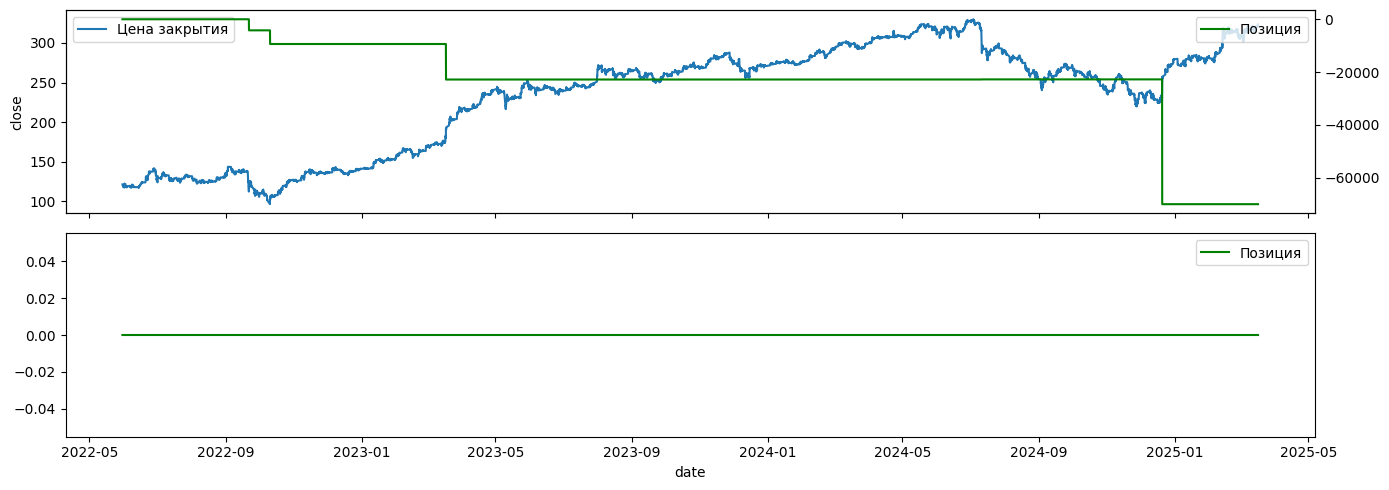

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(14, 5), sharex=True)

sns.lineplot(x=df['date'], y=df['close'], ax=ax[0], label='Цена закрытия')

ax_right = ax[0].twinx()

sns.lineplot(x=df['date'], y=rewards, ax=ax_right, label='Позиция', c='g')
sns.lineplot(x=df['date'], y=actions, ax=ax[1], label='Позиция', c='g')

# plt.axvline(x1, ls=':', c='r')
# plt.xlabel('label')
# plt.legend(['1', '2', '3'])
# ax_right.legend(loc='bottom right')
ax_right.grid(False)
# plt.xlim(df['date'].iloc[0], df['date'].iloc[500])
plt.tight_layout()
plt.show()
plt.close()

In [19]:
# from gym_trading_env.renderer import Renderer
# renderer = Renderer(render_logs_dir="logs")
# renderer.run()